# 1.1 Install Dependencies and setup

In [16]:
# !pip install labelme tensorflow opencv-python matplotlib albumentations

labelme 5.4.1


# 1.2 collect images using OpenCV

In [29]:
import os
import time
import uuid
import cv2

In [18]:
# uuid operation (uniform unique id)
uuid.uuid1()

UUID('be32a2a3-ea9c-11ee-906a-b42e996e5f84')

In [2]:
IMAGE_PATH = os.path.join('data','images')
number_images=30

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print(f'Collecting image {imgnum}')
    ret, frame = cap.read()
    imgname=os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break;
cap.release()
cv2.destroyAllWindows()

# 1.3 Annotate Images with LabelMe

In [8]:
!labelme

2024-03-25 18:18:37,357 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Anonymous\.labelmerc


# 2. Review Dataset and build Image Loading Function

# 2.1 import TF and Deps     

In [10]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

# 2.2 Limit GPU memory growth

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2.3 Load Image into TF Data Pipeline

In [7]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)
images.as_numpy_iterator().next()

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [12]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [24]:
images = images.map(load_image)

In [27]:
# images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

# 2.4 View Raw Images with Matplotlib

In [28]:
image_generator = images.batch(4).as_numpy_iterator()

In [36]:
plot_images = image_generator.next()

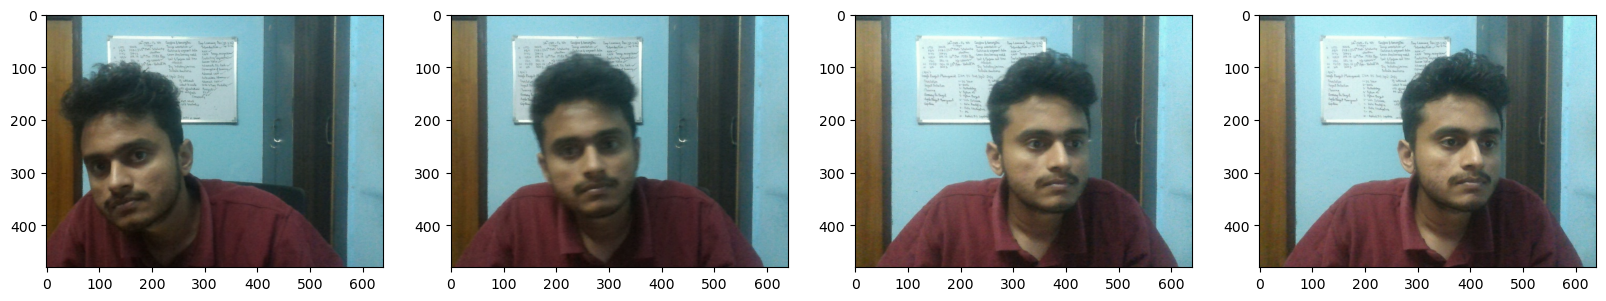

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data
- 70% training data - 63 images
- 14 images test and 13 images to validation 

# 3.2 Move the Matching labels

In [38]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename=file.split('.')[0]+'.json'
        existing_filepath=os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

# 4 Apply Image Augmentation on Images and Labels using Albumentations

In [9]:
import albumentations as alb


In [8]:
augmentor=alb.Compose([
    alb.RandomCrop(width=450,height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations',label_fields=['class_labels'])                        
)

# 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [7]:
img=cv2.imread(os.path.join('data','train','images','02e28dea-eaa0-11ee-a6f5-b42e996e5f84.jpg'))


In [8]:
with open(os.path.join('data','train','labels','02e28dea-eaa0-11ee-a6f5-b42e996e5f84.json'),'r') as f:
    label=json.load(f)

In [9]:
label['shapes'][0]['points']

[[213.84615384615384, 86.15384615384616],
 [412.3076923076923, 368.46153846153845]]

# 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [10]:
coords = [0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [11]:
coords

[213.84615384615384, 86.15384615384616, 412.3076923076923, 368.46153846153845]

In [12]:
coords = list(np.divide(coords,[640,480,640,480]))
# raw to albumentation 
coords

[0.33413461538461536,
 0.1794871794871795,
 0.6442307692307693,
 0.7676282051282051]

# 4.4 apply Augmentations and view results

In [13]:
augmented = augmentor(image=img,bboxes=[coords], class_labels=['face'])
print(augmented['image'].shape)
print(augmented['bboxes'])
augmented.keys()

(450, 450, 3)
[(0.37931623931623926, 0.18256410256410258, 0.8203418803418804, 0.80991452991453)]


dict_keys(['image', 'bboxes', 'class_labels'])

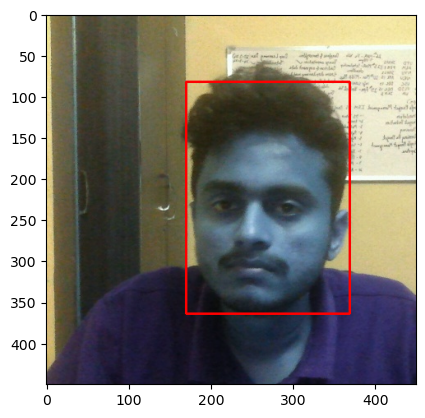

In [14]:
cv2.rectangle(
    augmented['image'],
    tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
    tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
    (255,0,0),
    2
)
plt.imshow(augmented['image'])

# 5 Build and run Augmentation Pipeline

# 5.1 Run Augmentation Pipeline

In [46]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))

        coords=[0,0,0.00001,0.00001]
        label_path=os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label=json.load(f)
            coords[0]=label['shapes'][0]['points'][0][0]
            coords[1]=label['shapes'][0]['points'][0][1]
            coords[2]=label['shapes'][0]['points'][1][0]
            coords[3]=label['shapes'][0]['points'][1][1]
            coords=list(np.divide(coords,[640,480,640,480]))

        try:
            for x in range(60):
                augmented=augmentor(image=img,bboxes=[coords],class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])

                annotation={}
                annotation['image']=image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) ==0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['classes'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox']=[0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data',partition,'labels', f'{image.split(".")[0]}.{x}.json'),'w') as f:
                    json.dump(annotation,f)
        except Exception as e:
            print(e)

# 5.2 Load Augmented Images to tensorflow dataset

In [13]:
train_images=tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg',shuffle=False)
train_images=train_images.map(load_image)
train_images=train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images=train_images.map(lambda x: x/255)

test_images=tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg',shuffle=False)
test_images=test_images.map(load_image)
test_images=test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images=test_images.map(lambda x: x/255)

val_images=tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg',shuffle=False)
val_images=val_images.map(load_image)
val_images=val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images=val_images.map(lambda x: x/255)


In [14]:
train_images.as_numpy_iterator().next()

array([[[0.4617647 , 0.5348039 , 0.547549  ],
        [0.45392156, 0.516299  , 0.51617646],
        [0.4559436 , 0.5183211 , 0.5185049 ],
        ...,
        [0.5505515 , 0.609375  , 0.5976103 ],
        [0.55949754, 0.59528184, 0.5923407 ],
        [0.6982843 , 0.7132966 , 0.6314951 ]],

       [[0.46954656, 0.5362745 , 0.5503064 ],
        [0.45839462, 0.5211397 , 0.52156866],
        [0.44791666, 0.5093137 , 0.51121324],
        ...,
        [0.55802697, 0.6153799 , 0.59724265],
        [0.53431374, 0.5726716 , 0.57751226],
        [0.7038603 , 0.7219363 , 0.64001226]],

       [[0.46078432, 0.53137255, 0.5392157 ],
        [0.44699755, 0.52542895, 0.5215074 ],
        [0.4473652 , 0.52567405, 0.5296569 ],
        ...,
        [0.5903186 , 0.63253677, 0.61832106],
        [0.5559436 , 0.5622549 , 0.5779412 ],
        [0.71427697, 0.7115196 , 0.6363358 ]],

       ...,

       [[0.35196078, 0.29246324, 0.2998162 ],
        [0.3514706 , 0.29558823, 0.29607844],
        [0.37493873, 0

# 6. Prepare labels 

# 6.1 Build Label Loading function

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf=8") as f:
        label=json.load(f)

    return [label['class']], label['bbox']


# 6.2 Load Labels to Tensorflow Dataset

In [16]:
train_labels=tf.data.Dataset.list_files('aug_data\\train\\labels\\*json',shuffle=False)
# train_labels.as_numpy_iterator().next()
train_labels=train_labels.map(lambda x:tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))
# train_labels.as_numpy_iterator().next()

In [17]:
test_labels=tf.data.Dataset.list_files('aug_data\\test\\labels\\*json',shuffle=False)
# train_labels.as_numpy_iterator().next()
test_labels=test_labels.map(lambda x:tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))

In [18]:
val_labels=tf.data.Dataset.list_files('aug_data\\val\\labels\\*json',shuffle=False)
# train_labels.as_numpy_iterator().next()
val_labels=val_labels.map(lambda x:tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))

In [19]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2048, 0.1448, 0.663 , 0.8335], dtype=float16))

# 7. Combine Label and Image Samples

# 7.1 check the partition lengths

In [20]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [21]:
train = tf.data.Dataset.zip((train_images, train_labels))
train= train.shuffle(5000)
train=train.batch(8)
train= train.prefetch(4)

In [22]:
test=tf.data.Dataset.zip((test_images,test_labels))
test=test.shuffle(1300)
test=test.batch(8)
test=test.prefetch(4)

In [23]:
val=tf.data.Dataset.zip((val_images, val_labels))
val=val.shuffle(1000)
val=val.batch(8)
val=val.prefetch(4)

In [24]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [25]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.1328, 0.155 , 0.5347, 0.731 ],
        [0.3726, 0.1329, 0.827 , 0.8286],
        [0.5347, 0.248 , 0.863 , 0.73  ],
        [0.181 , 0.1195, 0.5825, 0.6953],
        [0.    , 0.    , 0.    , 0.    ],
        [0.4426, 0.3188, 0.836 , 0.895 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.6836, 0.233 , 1.    , 0.6943]], dtype=float16))

# 7.3 view images and annotations 

In [36]:
data_samples=train.as_numpy_iterator()

In [27]:
res=data_samples.next()
res[1][1][1]

array([0.2404, 0.2515, 0.5703, 0.74  ], dtype=float16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


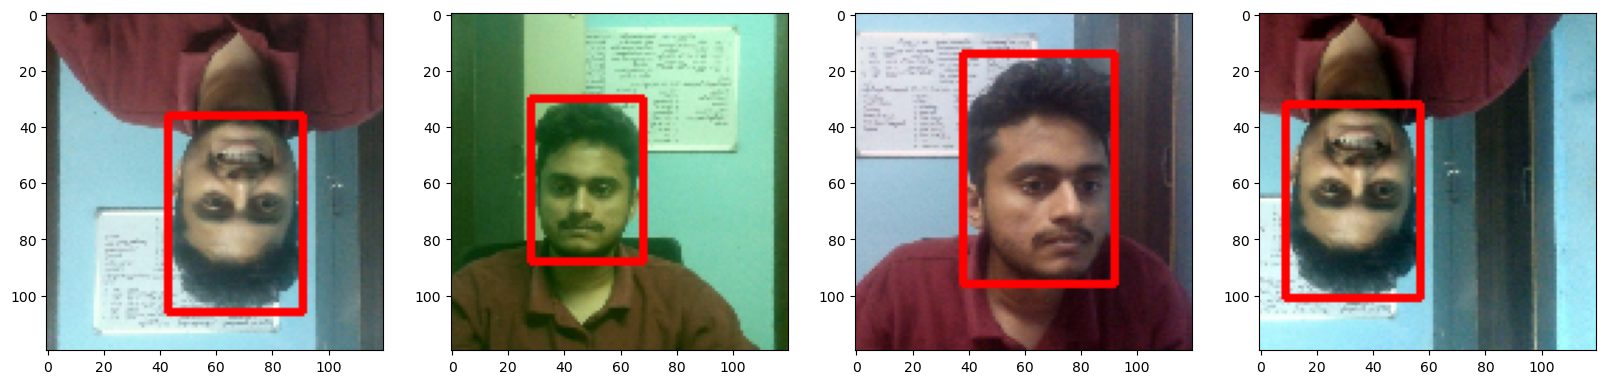

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_image = sample_image.copy()
    cv2.rectangle(
        sample_image,
        tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
        tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
        (255,0,0),
        2
    )

    ax[idx].imshow(sample_image)

# 8. Build and train the deep learning Model

# 8.1 Import Layers and Base Network

In [44]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, MaxPooling2D
# from tensorflow.keras.applications import VGG16
# from keras.layers import GlobalMaxPooling2D, Dense
from keras.applications import VGG16

# 8.2 Download VGG16

In [32]:
vgg= VGG16(include_top=False)

In [33]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# 8.3 build instance of network

In [137]:
def build_model():
    input_layer=Input(shape=(120,120,3))
    vgg=VGG16(include_top=False)(input_layer)
          # call it on the given tensor
    f1=GlobalMaxPooling2D()(vgg)
    class1=Dense(2048,activation='relu')(f1)
    class2=Dense(1,activation='sigmoid')(class1)
    
    f2=GlobalMaxPooling2D()(vgg)
    regress1=Dense(2048,activation='relu')(f2)
    regress2=Dense(4,activation='sigmoid')(regress1)
  

    facetracker = Model(inputs=input_layer, outputs=[class2,regress2])
    return facetracker

In [138]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.1832, 0.299 , 0.5215, 0.752 ],
        [0.0997, 0.1193, 0.5254, 0.7397],
        [0.349 , 0.1051, 0.742 , 0.681 ],
        [0.3296, 0.187 , 0.745 , 0.852 ],
        [0.4075, 0.2051, 0.785 , 0.718 ],
        [0.2803, 0.2947, 0.6064, 0.785 ],
        [0.3643, 0.2874, 0.689 , 0.7866],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

# 8.4 Test out Neural Network

In [139]:
facetracker=build_model()

In [140]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_13[0][0]']               
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                

In [154]:
x,y=train.as_numpy_iterator().next()
x.shape

(8, 120, 120, 3)

In [155]:
x,y

(array([[[[0.45992646, 0.6466912 , 0.6829657 ],
          [0.44650736, 0.6501838 , 0.6811887 ],
          [0.43204656, 0.6401961 , 0.6696078 ],
          ...,
          [0.3011642 , 0.14803922, 0.15196079],
          [0.32561275, 0.16678922, 0.16776961],
          [0.34123775, 0.17346814, 0.1764706 ]],
 
         [[0.50667894, 0.6586397 , 0.69307595],
          [0.4922794 , 0.6700368 , 0.6922181 ],
          [0.45667893, 0.65477943, 0.67132354],
          ...,
          [0.2867647 , 0.13468137, 0.13817401],
          [0.32647058, 0.15588236, 0.15980393],
          [0.3521446 , 0.17469363, 0.18106617]],
 
         [[0.47696078, 0.6485294 , 0.69215685],
          [0.47144607, 0.6444853 , 0.67830884],
          [0.48921567, 0.66182595, 0.7029412 ],
          ...,
          [0.23419118, 0.1302696 , 0.1264093 ],
          [0.2788603 , 0.14595588, 0.1420343 ],
          [0.3223652 , 0.16256127, 0.1637255 ]],
 
         ...,
 
         [[0.6248162 , 0.8483456 , 0.89148283],
          [0.62101

In [156]:
classes,coords=facetracker.predict(x)

1/1 [==============================] - 0s 25ms/step


In [157]:
classes.shape,coords.shape

((8, 1), (8, 4))

In [158]:
classes, coords

(array([[0.34802714],
        [0.34132838],
        [0.37634546],
        [0.27905446],
        [0.37507156],
        [0.28330144],
        [0.21370843],
        [0.4684355 ]], dtype=float32),
 array([[0.63246185, 0.581173  , 0.35587537, 0.2904049 ],
        [0.50017244, 0.5503107 , 0.37180164, 0.36735356],
        [0.63260907, 0.5936723 , 0.38608742, 0.27360967],
        [0.48978257, 0.5278372 , 0.39341024, 0.38398963],
        [0.4660378 , 0.5036304 , 0.3618547 , 0.40902457],
        [0.5326118 , 0.5180222 , 0.38624394, 0.3661322 ],
        [0.6341658 , 0.6849332 , 0.35468397, 0.3014764 ],
        [0.59709543, 0.68270737, 0.41010582, 0.27258748]], dtype=float32))

# 9 Define Loss and Optimizers

# 9.1 Define Optimizer and LR

In [159]:
len(train)

473

In [160]:
batches_per_epoch=len(train)
lr_decay=(1./0.75-1)/batches_per_epoch

In [161]:
print(lr_decay)

0.0007047216349541929


In [162]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

# 9.2 create localization loss and classification loss

In [163]:
def localization_loss(y_true,yhat):
    delta_coord=tf.reduce_sum(tf.square(y_true[:,:2]-yhat[:,:2]))

    h_true = y_true[:,3]-y_true[:,1]
    w_true = y_true[:,2]-y_true[:,0]

    h_pred = yhat[:,3]-yhat[:,1]
    w_pred = yhat[:,2]-yhat[:,0]

    delta_size=tf.reduce_sum(tf.square(w_true-w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [164]:
classloss=tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss
# coords=coords.reshape(8,4)
# coords, y[1]

# 9.3 Test out Loss Metrics

In [165]:
localization_loss(y[1], coords).numpy()
# coords=coords.reshape(8,4)
# coords, y[1]

7.774857

# 10 train neural network

# 10.1 Create custom model class

In [166]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model=facetracker


    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs=classloss
        self.lloss= localizationloss
        self.opt=opt

    def train_step(self,batch, **kwargs):

        x,y=batch
        with tf.GradientTape() as tape:
            classes, coords = self.model(x,training=True)

            batch_classloss=self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32),coords)

            total_loss = batch_localizationloss+0.5*batch_classloss
            grad= tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss": batch_localizationloss}
        
    def test_step(self,batch, **kwargs):

        x,y=batch
       
        classes, coords = self.model(x,training=True)

        batch_classloss=self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32),coords)

        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss": batch_localizationloss}


    def call(self, x, **kwargs):
        return self.model(x, **kwargs)
        
    
        

In [168]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

# 10.2 Train

In [174]:
logdir='logs'

In [175]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [171]:
hist=model.fit(train,epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
473/473 [==============================] - 37s 57ms/step - total_loss: 0.1329 - class_loss: 0.0286 - regress_loss: 0.1186 - val_total_loss: 0.0117 - val_class_loss: 1.7068e-04 - val_regress_loss: 0.0117
Epoch 2/40
473/473 [==============================] - 22s 43ms/step - total_loss: 0.0141 - class_loss: 8.5268e-05 - regress_loss: 0.0141 - val_total_loss: 0.0037 - val_class_loss: 1.0703e-04 - val_regress_loss: 0.0037
Epoch 3/40
473/473 [==============================] - 23s 43ms/step - total_loss: 0.0110 - class_loss: 3.6893e-05 - regress_loss: 0.0110 - val_total_loss: 0.0058 - val_class_loss: 7.9189e-05 - val_regress_loss: 0.0057
Epoch 4/40
473/473 [==============================] - 23s 44ms/step - total_loss: 0.0098 - class_loss: 2.5367e-05 - regress_loss: 0.0098 - val_total_loss: 0.0103 - val_class_loss: 3.2247e-05 - val_regress_loss: 0.0103
Epoch 5/40
473/473 [==============================] - 23s 43ms/step - total_loss: 0.0086 - class_loss: 1.4678e-05 - regress_loss: 0.